In [ ]:
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

#Shape Alignment

## Overview
Function that aligns two sets of points using iterative closest point (ICP) to output an affine image transformation $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$.




In [ ]:
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 20.1MB/s]
Archive:  /content/part2_images.zip
   creating: /content/part2_images/
 extracting: /content/part2_images/Bone_1.png  
 extracting: /content/part2_images/elephant_1.png  
 extracting: /content/part2_images/brick_2.png  
 extracting: /content/part2_images/Heart_2.png  
 extracting: /content/part2_images/Bone_2.png  
  inflating: /content/part2_images/elephant_2.png  
 extracting: /content/part2_images/brick_1.png  
 extracting: /content/part2_images/Heart_1.png  
  inflating: /content/part2_images/device7_1.png  
  inflating: /content/part2_images/device7_2.png  
 extracting: /content/part2_images/fork_2.png  
 extracting: /content/part2_images/turtle_2.png  
  inflating: /content/part2_images/fork_1.png  
 extracting: /content/part2_images/turtle_1.png  
 extracting: /content/part2_images/butterfly_2.png  
 extracting: /content/pa

## Helper Functions

In [ ]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2)
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d1[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x)
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time
     thick: true if a line should be thickened for display
  '''
  if thick:
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim


## Code

In [ ]:
import numpy as np
from scipy.spatial import KDTree

def align_shape(im1, im2):
    '''
    im1: input edge image 1
    im2: input edge image 2

    Output: transformation T [3] x [3]
    '''

    p1 = np.argwhere(im1 > 0)
    center1 = np.mean(p1, axis=0)
    p2 = np.argwhere(im2 > 0)
    center2 = np.mean(p2, axis=0)
    initial_translation = center2 - center1

    T = np.eye(3)
    T[0, 2] = initial_translation[1]
    T[1, 2] = initial_translation[0]

    for i in range(50):
        transformed = np.dot(np.hstack([p1, np.ones((p1.shape[0], 1))]), T.T)[:, :2]
        KDtree = KDTree(p2)
        dist, ind = KDtree.query(transformed)

        matched1 = transformed
        matched2 = p2[ind]

        M1 = np.zeros((matched1.shape[0] * 2, 6))
        M2 = matched2.reshape(-1, 1)

        for i, (a, b) in enumerate(matched1):
            M1[2*i] = [a, b, 1, 0, 0, 0]
            M1[2*i + 1] = [0, 0, 0, a, b, 1]

        updated, f2, f3, f4 = np.linalg.lstsq(M1, M2, rcond=None)
        T2 = np.array([[updated[0][0], updated[1][0], updated[2][0]],[updated[3][0], updated[4][0], updated[5][0]],[0, 0, 1]])

        T = T2

    return T

[[ 1.02754557e+00 -1.48587433e-04 -4.17144100e+00]
 [ 4.87817247e-03  1.05290704e+00 -5.76808737e+00]]


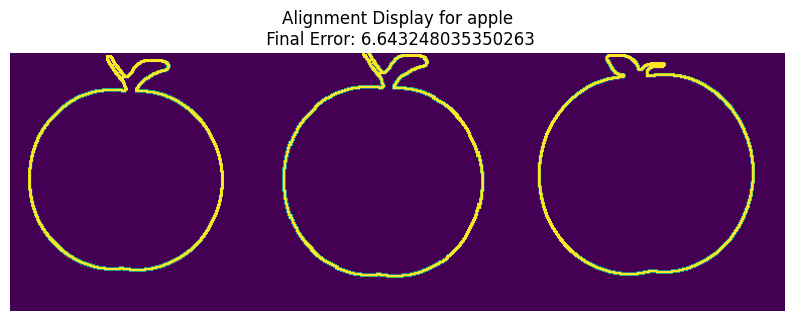

Runtime for apple: 1.7533326148986816 seconds
[[ 9.99421586e-01  1.01126118e-03 -5.05646446e-02]
 [ 3.67036682e-04  1.00084231e+00 -4.84019748e-01]]


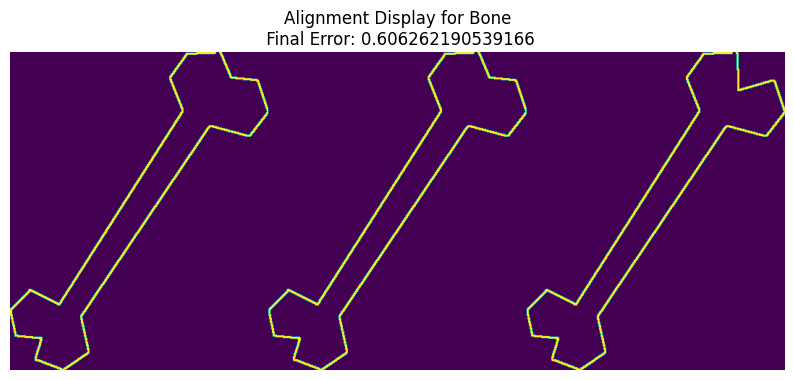

Runtime for Bone: 2.479862928390503 seconds
[[ 1.06884005e+00 -5.24645091e-04 -1.41544282e+01]
 [ 1.20574830e-02  1.03790459e+00 -9.19897179e+00]]


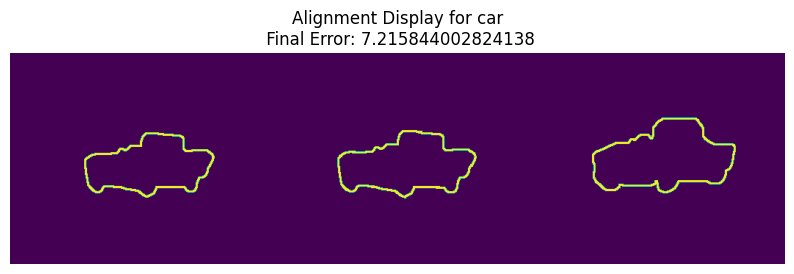

Runtime for car: 0.8801467418670654 seconds
[[ 1.00126881 -0.00204634 -0.10379347]
 [-0.0016494   1.01145119 -1.00710166]]


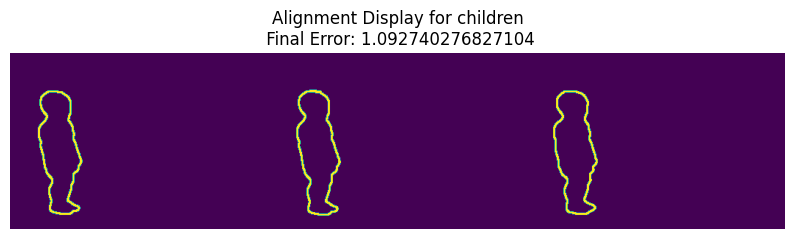

Runtime for children: 1.090449571609497 seconds
[[ 9.99763380e-01 -4.32304695e-04  6.95906048e-02]
 [ 4.47341918e-05  1.00041759e+00 -1.68711848e-01]]


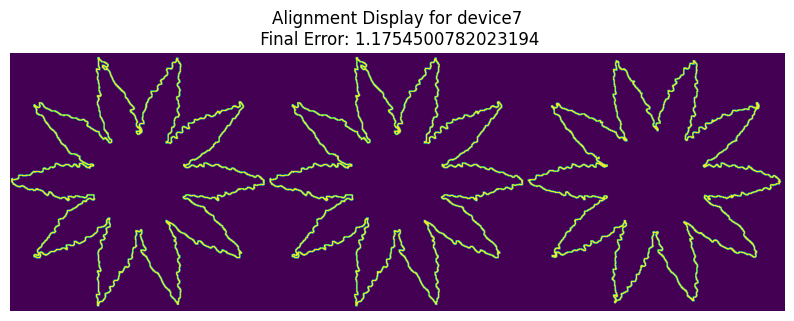

Runtime for device7: 7.8200953006744385 seconds
[[ 1.00644266  0.00343602 -2.09470664]
 [ 0.0028642   1.00180515 -1.09617984]]


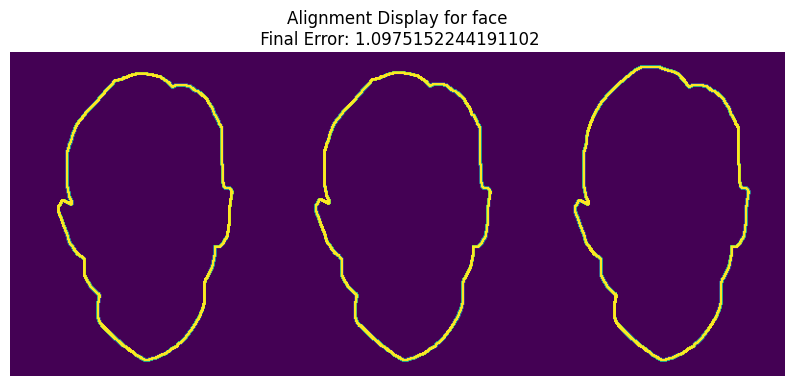

Runtime for face: 2.5924320220947266 seconds
[[ 1.00561547e+00 -4.37021800e-04 -2.11273190e+00]
 [ 5.15793401e-04  9.98752463e-01  1.22568874e-01]]


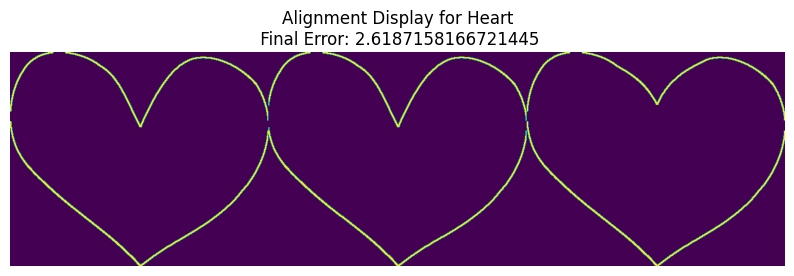

Runtime for Heart: 4.012461423873901 seconds
[[ 0.99087779 -0.0090296   0.78465111]
 [-0.03132222  0.99513217  5.48111026]]


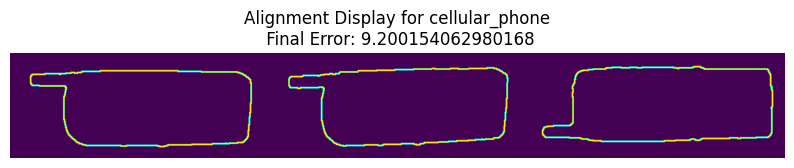

Runtime for cellular_phone: 2.7297346591949463 seconds
[[ 9.99229797e-01  1.57228260e-03 -2.64180655e-01]
 [ 1.60559709e-03  9.74726811e-01  5.93134817e+00]]


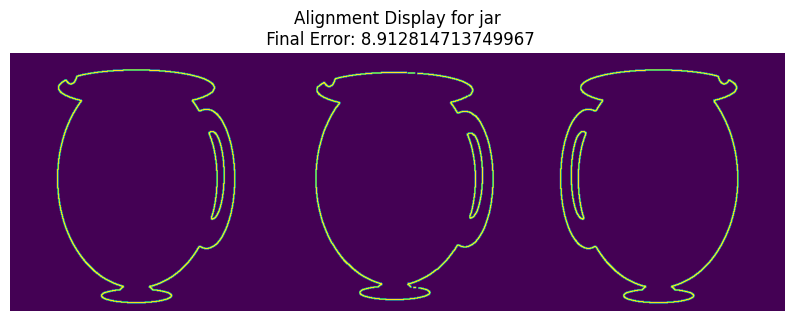

Runtime for jar: 4.820171356201172 seconds
[[ 1.0044365  -0.01280527  1.79957851]
 [-0.00513583  1.00715844 -3.44093772]]


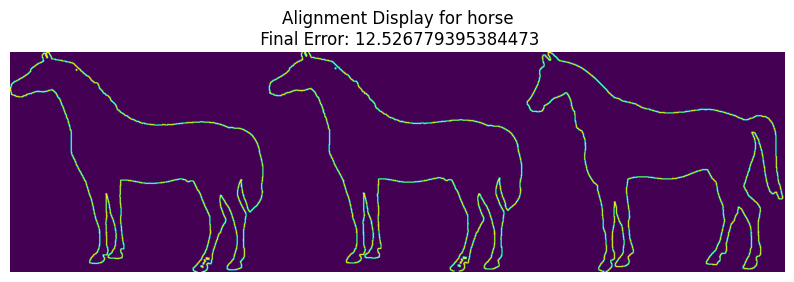

Runtime for horse: 6.133026838302612 seconds


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import ndimage

imgPath = '/content/part2_images/'

objList = [
    'apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick',
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone',
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer',
    'Heart', 'horse', 'jar', 'turtle'
]

objList = ['apple', 'Bone', 'car', 'children', 'device7', 'face', 'Heart', 'cellular_phone', 'jar', 'horse']

numObj = len(objList)
im2 = cv2.imread("/content/part2_images/apple_1.png",cv2.IMREAD_GRAYSCALE)
im2 = im2/255.0

for i in range(numObj):
    start = time()
    image_1 = imgPath + objList[i] + '_1.png'
    image_2 = imgPath + objList[i] + '_2.png'
    im1 = cv2.imread(image_1, cv2.IMREAD_GRAYSCALE)
    im2 = cv2.imread(image_2, cv2.IMREAD_GRAYSCALE)

    im1 = im1 / 255.0
    im2 = im2 / 255.0

    T_Affine = align_shape(im1, im2)[:2, :3]

    aligned_img = cv2.warpAffine(im1, T_Affine, (im2.shape[1], im2.shape[0]), flags =cv2.INTER_NEAREST)

    display_img = displayAlignment(im1, im2, aligned_img, thick=True)

    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(display_img)
    error = evalAlignment(aligned_img, im2)
    plt.title(f'Alignment Display for {objList[i]}\n Final Error: {error}')
    plt.show()

    run_time = time() - start
    print(f"Runtime for {objList[i]}: {run_time} seconds")



The algorithm works to align two sets of points from two seperate images, using iterative closest point, to output an affine image transformation. These image transformations are then warped. Finally the error between the warped image and image 2 can be identified, which indicates the success of the alignment process. The algorithm takes in two greyscale images and first finds the edge points in both images. Then the initial transformation is computed by using the center of mass of the edge points. The initial transformation matrix is based off an identify matrix that includes the previously computed translations. The model of the transformation itself goes through 50 iterations where each time it finds the nearest neighbors in the second image for each transformed point in the first image. Finally, a system of equations is set up and solved to minimize the distance between the matched points. After all 50 iterations, the new aligned transformation matrix is returned.

#Object Instance Recognition

## Overview
Explores the Lowe-style object instance recognition.Implements the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.



In [ ]:
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J

Downloading...
From (original): https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
From (redirected): https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM&confirm=t&uuid=49b58c6c-0f16-49b6-bc83-12b9f3af96c2
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 55.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 31.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 30.6MB/s]


## Code (10 pts)

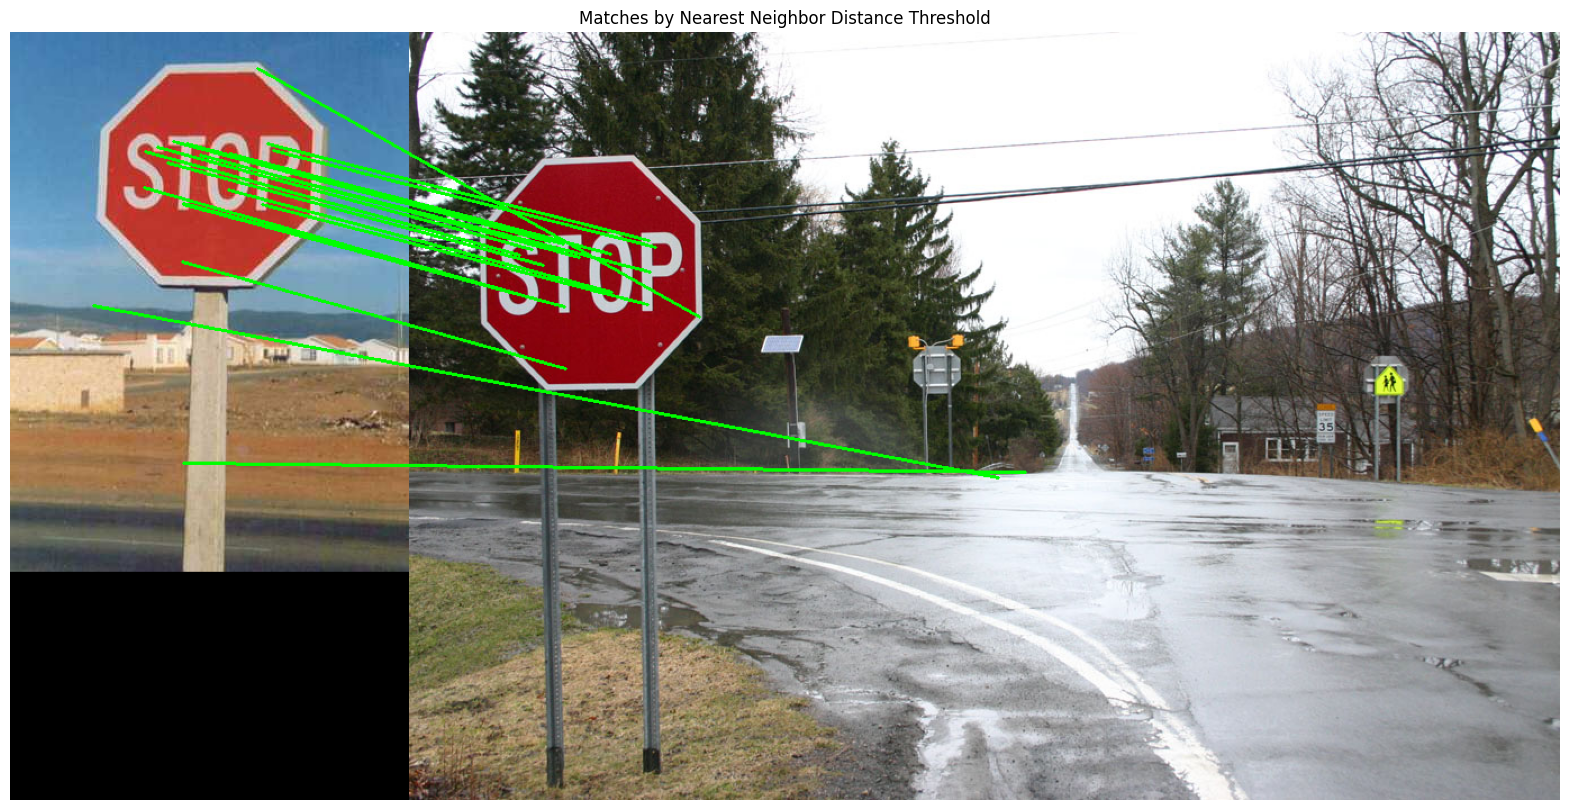

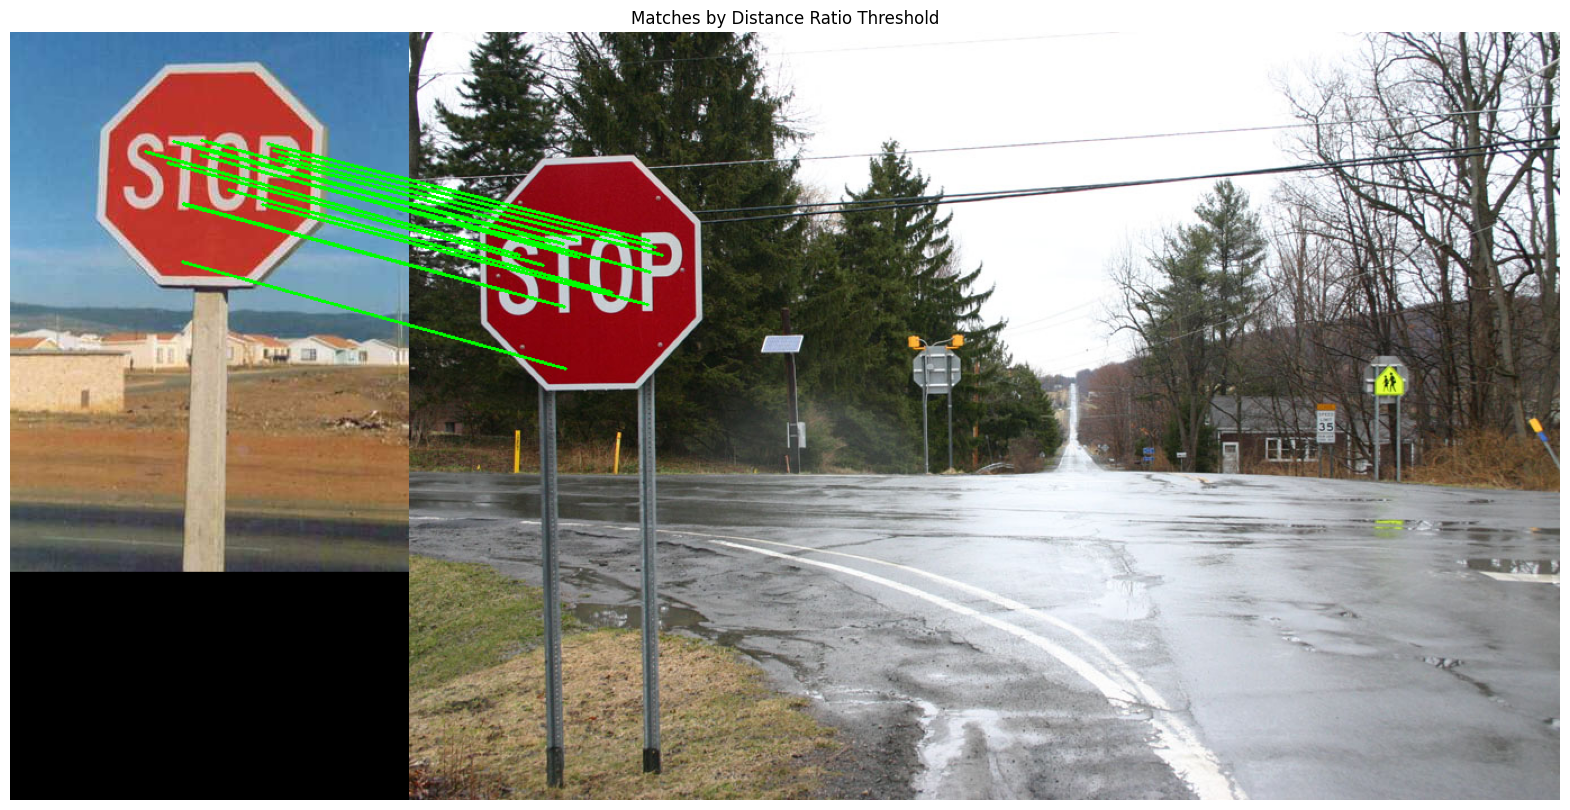

In [ ]:
import numpy as np
import cv2
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')

data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']

Descriptor1 = Descriptor1.T
Descriptor2 = Descriptor2.T

distances = cdist(Descriptor1, Descriptor2, 'euclidean')

sort_dist = np.argsort(distances, axis=1)
closest = distances[np.arange(distances.shape[0]), sort_dist[:, 0]]
second = distances[np.arange(distances.shape[0]), sort_dist[:, 1]]

matches1 = []
neighbor_distance_threshold = 125
for i in range(len(closest)):
    if closest[i] < neighbor_distance_threshold:
        matches1.append([i, sort_dist[i, 0]])
matches1 = np.array(matches1)

distance_ratio_threshold = 0.5
matches2 = []
for i, (closest, second) in enumerate(zip(closest, second)):
    if closest < distance_ratio_threshold * second:
        matches2.append([i, sort_dist[i, 0]])
matches2 = np.array(matches2)


height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]
height_fin = max(height1, height2)
final_img = np.zeros((height_fin, (width1 + width2), 3), dtype=np.uint8)
final_img[:height1, :width1, :] = img1
final_img[:height2, width1: width1+width2, :] = img2

for line in matches1:
    point_1img = (int(Frame1[0, line[0]]), int(Frame1[1, line[0]]))
    point_2img = (int(Frame2[0, line[1]]) + width1, int(Frame2[1, line[1]]))
    cv2.line(final_img, point_1img, point_2img, (0, 255, 0), 2)

final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 15))
plt.imshow(final_img)
plt.title("Matches by Nearest Neighbor Distance Threshold")
plt.axis('off')
plt.show()


height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]
height_fin = max(height1, height2)
final_img = np.zeros((height_fin, (width1 + width2), 3), dtype=np.uint8)
final_img[:height1, :width1, :] = img1
final_img[:height2, width1:width1+width2, :] = img2

for line in matches2:
    point_1img = (int(Frame1[0, line[0]]), int(Frame1[1, line[0]]))
    point_2img = (int(Frame2[0, line[1]]) + width1, int(Frame2[1, line[1]]))
    cv2.line(final_img, point_1img, point_2img, (0, 255, 0), 2)

final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 15))
plt.imshow(final_img)
plt.title("Matches by Distance Ratio Threshold")
plt.axis('off')
plt.show()


There is a distinct difference between the method of matching by thresholding nearest neighbor distances compared to matching by tresholding the distance ratio.For starters, the treshold value for nearest neighbor distances is a constant value of 150. This means that any distances greater than this treshold value are filtered out and not considered. On the other hand, the threshold value for the distance ratio is a decimal from 0 - 1 (0.76). In this method the distance of closest neighbor is compared to the distance of the second neighbor * the threshold value. If the distance of the closest is less than the distance of the second * the treshold value, this match is added, otherwise the match is filtered out. The distance ratio method considers the relative distances of two neighbor matches, while the nearest neighbor distances method is more straightforward and does not consider this.